# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip


!unzip -q data.zip

--2023-12-07 13:37:34--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-07 13:37:34--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.05s   

2023-12-07 13:37:35 (314 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchvision import transforms

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        bndbox = member.find('bndbox')
        xmin = bndbox.find('xmin').text
        ymin = bndbox.find('ymin').text
        xmax = bndbox.find('xmax').text
        ymax = bndbox.find('ymax').text
        class_1 = class_dict[member.find('name').text]
        res = (int(xmin), int(ymin), int(xmax), int(ymax), class_1)

        bboxes.append(res)

    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):

        fname = self.filenames[idx]

        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [7]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        Inverse_Transform = transforms.Compose([transforms.Normalize(mean = [0., 0., 0.],
                                                                     std = [1/0.229, 1/0.224, 1/0.225]),
                                                transforms.Normalize(mean = [-0.485, -0.456, -0.406],
                                                                    std = [1., 1., 1.]),])
        tensor = Inverse_Transform(images[i])
        ax.imshow(tensor.permute((1, 2, 0)))

        for bbox in bboxes[i]:
          xmin, ymin, xmax, ymax, class_1 = bbox[0], bbox[1], bbox[2], bbox[3], bbox[4]
          name = train_ds.class_dict_inv[class_1]
          rectangle = Rectangle((xmin, ymin), width = xmax-xmin, height = ymax-ymin, linewidth=1, edgecolor='g', facecolor = 'none')
          ax.add_patch(rectangle)
          ax.text(x = xmin, y = ymin + 1.5, s = name, color = 'g')

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

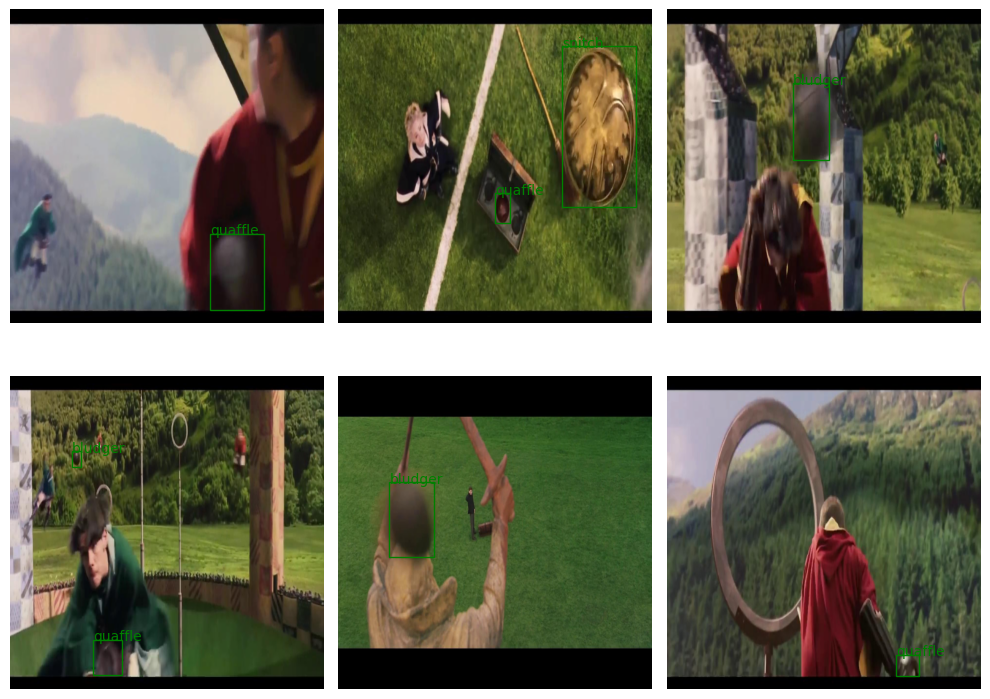

In [8]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [9]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  downsample
        y_cell =  downsample
        w_box =  ((xmax - xmin) / w) #отнормированная ширина бокса
        h_box = ((ymax - ymin) / h) #высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx = (xmax + xmin) / 2 #(координаты центра в исходных координатах)
        cy = (ymax + ymin) / 2
        cx_idx = cx // x_cell #(посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx = cy // y_cell

        cx_box = ((cx - cx_idx * x_cell) / x_cell) #(посчитайте сдивиги относительно cx_idx)
        cy_box = ((cy - cy_idx * y_cell) / y_cell)

        target[i, :, cy_idx.to(torch.long), cx_idx.to(torch.long)] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

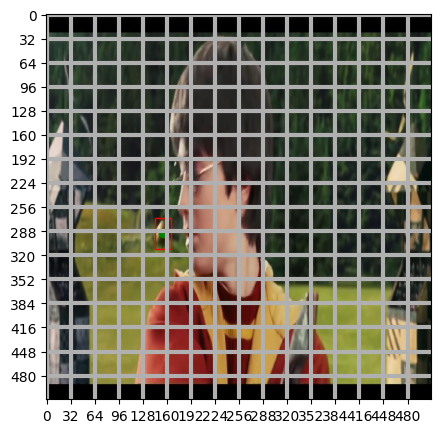

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [11]:
def decode_prediction(pred, upsample=32, threshold=0.7):

  b, c, h, w = pred.shape
  img_w, img_h = w * upsample, h * upsample
  bboxes_pred = [[] for x in range(b)]

  for pic in range(b):
    for i in range(h):
      for j in range(w):

        if pred[pic, 4, i, j] > threshold:
          cx_box, cy_box, w_box, h_box = pred[pic, :4, i, j]


          w_i = w_box * img_w
          h_i = h_box * img_h

          cx = (cx_box * upsample) + (j * upsample)
          cy = (cy_box * upsample) + (i * upsample)

          xmin = cx - (w_i / 2)
          xmax = cx + (w_i / 2)
          ymin = cy - (h_i / 2)
          ymax = cy + (h_i / 2)
          if c > 6:
            class_pred =  torch.argmax(pred[pic, 5:, i, j])
          else:
            class_pred = pred[pic, 5, i, j]

          bboxes_pred[pic] = [xmin.item(), ymin.item(), xmax.item(), ymax.item(), class_pred.item()]


  return bboxes_pred

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [12]:
C = 3

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.layer1 = nn.Sequential(*list(model.children())[:8])
        self.layer2 = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5+C, kernel_size=3, padding=1),
        )

    def forward(self, img):

        x = self.layer1(img)
        x = self.layer2(x)
        x = torch.sigmoid(x)

        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [13]:
def get_mask(pred, target):
  b, _, w, h = target.shape
  mask_for_target_1 = []
  mask_for_pred_1 = []
  mask_for_target_0 = []
  mask_for_pred_0 = []
  for pic in range(b):
    for i in range(w):
      for j in range(h):
        if target[pic, 4, i, j] == 1:
          mask_for_target_1.append(target[pic, :, i, j])
          mask_for_pred_1.append(pred[pic, :, i, j])
        else:
          mask_for_target_0.append(target[pic, :, i, j])
          mask_for_pred_0.append(pred[pic, :, i, j])

  detected_target = torch.stack(mask_for_target_1)
  detected_pred = torch.stack(mask_for_pred_1)

  undetected_target = torch.stack(mask_for_target_0)
  undetected_pred = torch.stack(mask_for_pred_0)

  return detected_target, detected_pred, undetected_target, undetected_pred

In [14]:
def special_loss(pred, target, check=False, C=3):
  b, _, w, h = target.shape

  res = get_mask(pred, target)

  detected_target = res[0]
  detected_pred = res[1]
  undetected_target = res[2]
  undetected_pred = res[3]

  localization_loss = nn.MSELoss(reduction='sum')(detected_pred[:, :2], detected_target[:, :2])

  box_loss = nn.MSELoss(reduction='sum')(torch.sqrt(detected_pred[:, 2:4]), torch.sqrt(detected_target[:, 2:4]))

  classification_loss = nn.CrossEntropyLoss(reduction='sum')(detected_pred[:, 5:(5+C)], detected_target[:, 5].long())

  confidence_loss_detectable = nn.BCELoss(reduction='sum')(detected_pred[:, 4], detected_target[:, 4])

  confidence_loss_nondetectable = nn.BCELoss(reduction='sum')(undetected_pred[:, 4], undetected_target[:, 4])

  confidence_loss = confidence_loss_detectable + confidence_loss_nondetectable


  if not check:
      return localization_loss + box_loss + classification_loss + confidence_loss

  else:
      return localization_loss, box_loss, classification_loss, confidence_loss

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [15]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 20
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    model.train()
    for batch in pbar:
        imgs = batch["image"].to(device)
        targets = batch["target"].to(device)

        preds = model(imgs)

        loss = special_loss(preds, targets)

        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_losses.append(loss.item())
        pbar.set_description(f"Loss: {loss.item():.3f}")

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 561.039;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 124.042;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 77.302;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 51.268;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 37.409;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 31.101;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 29.003;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 25.342;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 22.929;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 20.318;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 19.284;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 17.467;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 14.160;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 13.722;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 12.029;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 10.956;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 9.470;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 9.179;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 8.355;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 8.167;


Запустим обученный детектор на тестовых изображениях:

In [17]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

with torch.no_grad():
  imgs = batch["image"].to(device)
  preds = model(imgs)
  preds = decode_prediction(preds, threshold=0.1)
len(preds)

6

In [18]:
def visualize_1(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        Inverse_Transform = transforms.Compose([transforms.Normalize(mean = [0., 0., 0.],
                                                                     std = [1/0.229, 1/0.224, 1/0.225]),
                                                transforms.Normalize(mean = [-0.485, -0.456, -0.406],
                                                                    std = [1., 1., 1.]),])
        tensor = Inverse_Transform(images[i])
        ax.imshow(tensor.permute((1, 2, 0)))

        if len(bboxes[i]) != 0: #перепишем старую функцию с учетом того, что на картинке всегда один бибокс
          xmin, ymin, xmax, ymax, class_1 = bboxes[i][0], bboxes[i][1], bboxes[i][2], bboxes[i][3], bboxes[i][4]
          name = train_ds.class_dict_inv[class_1]
          rectangle = Rectangle((xmin, ymin), width = xmax-xmin, height = ymax-ymin, linewidth=1, edgecolor='g', facecolor = 'none')
          ax.add_patch(rectangle)
          ax.text(x = xmin, y = ymin + 1.5, s = name, color = 'g')

    fig.tight_layout()
    plt.show()

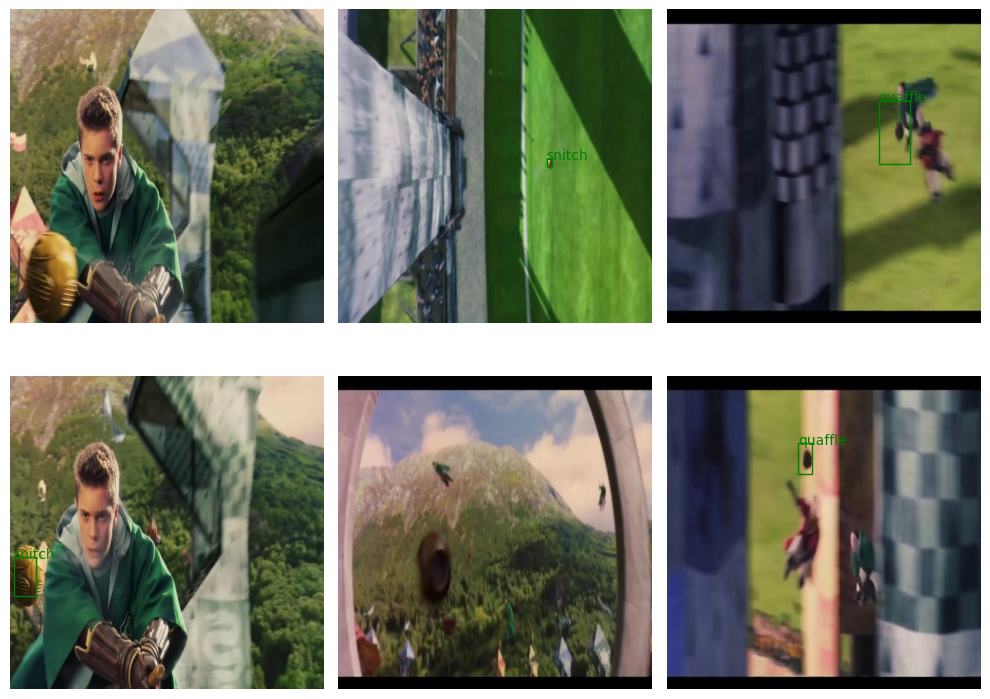

In [19]:
visualize_1(imgs.cpu(), preds)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 13.0 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
import json

In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    xmin = bboxes[0]
    ymin = bboxes[1]
    xmax = bboxes[2]
    ymax = bboxes[3]
    classs = str(bboxes[4])
    a = str((xmax + xmin) / (2 * w_im))
    b = str((ymax + ymin) / (2 * h_im))
    c = str((xmax - xmin) / w_im)
    d = str((ymax - ymin) / h_im)
    return [classs, a, b, c, d]

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\t".join(annotation2txt(result[1][0], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\t".join(annotation2txt(result[1][0], w_im, h_im)))

In [ ]:
# Собираем YAML
#{'snitch': 0, 'quaffle': 1, 'bludger': 2}
nc =  3
names =  ['snitch', 'quaffle', 'bludger']

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
import ultralytics
model = ultralytics.YOLO('yolov8n.yaml')
results = model.train(data='data.yaml', epochs=100, imgsz=512)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/train/labels.cache... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.98G      5.078      9.769      4.202         28        512: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         29         29          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.97G      5.065      9.087      4.175         29        512: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         29         29   8.64e-05     0.0556    9.5e-05    1.9e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.97G      4.418      7.978      3.913         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         29   0.000189     0.0556   0.000137   2.74e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.97G      3.909      7.024       3.62         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         29         29   0.000351     0.0556   0.000207   4.14e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.97G      3.493      6.254       3.33         32        512: 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         29         29   0.000345     0.0556   0.000207   4.14e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.97G      3.329       6.38      3.102         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         29         29   0.000345     0.0556   0.000207   4.14e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.97G      3.108      5.329      2.817         29        512: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         29         29   0.000345     0.0556   0.000207   4.14e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.97G      3.155      5.149      2.657         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         29         29    0.00111      0.229    0.00333    0.00156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.97G      2.966      4.728      2.508         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         29         29     0.0168      0.209     0.0301     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.97G      2.798      4.584      2.309         21        512: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         29         29      0.822     0.0196     0.0321     0.0153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.97G      2.688      4.013      2.255         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         29         29      0.412     0.0392     0.0497     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.97G      2.593      3.759      2.264         31        512: 100%|██████████| 16/16 [00:03<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         29         29      0.124     0.0196      0.043     0.0206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.97G      2.554      3.692      2.201         30        512: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         29         29       0.23     0.0752     0.0693     0.0425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.97G      2.557       3.56      2.194         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         29         29      0.185     0.0752      0.121     0.0711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.97G      2.539      3.433      1.976         28        512: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         29         29      0.226      0.134      0.139      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.97G      2.494      3.324      2.021         23        512: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         29         29      0.119       0.23      0.123     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.97G      2.471      3.174       1.93         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         29         29      0.231      0.134      0.154     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.97G      2.445      3.149      1.958         32        512: 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         29         29       0.21      0.297      0.201     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.97G      2.288      2.855      2.004         21        512: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         29      0.176      0.147      0.154     0.0723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.97G      2.358      3.036      1.926         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         29      0.716       0.15      0.271      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.97G      2.238      2.767      1.722         23        512: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         29         29      0.304      0.309      0.265      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.97G      2.185      2.655      1.768         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         29      0.293      0.293      0.264      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.97G      2.038      2.399      1.643         20        512: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         29         29      0.368      0.304      0.291      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.97G      2.066      2.436      1.651         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         29         29      0.447      0.184      0.228      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.97G      2.193      2.472      1.724         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         29         29      0.461      0.274      0.254      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.97G      2.146      2.481      1.747         29        512: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         29         29      0.212      0.224      0.265      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.97G      2.062      2.219      1.697         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         29         29      0.483      0.307      0.337      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.97G      2.024      2.305      1.656         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         29      0.734      0.292      0.382      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.97G      1.952       2.21      1.572         24        512: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         29         29      0.701      0.307      0.416      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.97G      2.025      2.179       1.53         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         29         29      0.517      0.307      0.367       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.97G      2.082      2.228      1.606         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         29         29      0.402      0.359      0.367      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.97G      2.082      2.187      1.675         30        512: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         29         29      0.682      0.292      0.351      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.97G      1.993      2.161      1.535         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         29         29      0.309      0.443      0.339      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.97G      1.933      2.069       1.55         22        512: 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         29         29       0.56       0.34      0.342      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.97G      1.862      1.995      1.542         26        512: 100%|██████████| 16/16 [00:04<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         29         29      0.529      0.399      0.326      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.97G      2.009      2.154      1.628         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         29      0.724      0.238      0.395       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.97G      1.952      1.904      1.517         27        512: 100%|██████████| 16/16 [00:05<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         29         29      0.483       0.32       0.38      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.97G      1.865      1.831      1.455         22        512: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         29         29      0.724       0.32      0.418      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.97G      1.875      1.895      1.524         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         29         29      0.576      0.359       0.45      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.97G      1.983      1.996      1.599         22        512: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         29         29      0.487      0.359      0.434      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.97G      1.786      1.715      1.413         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         29         29      0.843      0.356      0.495      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.97G      1.819      1.771       1.49         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         29         29      0.822       0.34        0.5      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.97G      1.829      1.772      1.523         21        512: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         29         29      0.461      0.454      0.498      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.97G      1.756      1.651      1.437         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         29         29      0.496      0.386      0.452      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.97G      1.833      1.836      1.482         19        512: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         29         29      0.783      0.351      0.485      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.97G      1.721       1.67      1.443         25        512: 100%|██████████| 16/16 [00:03<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         29         29      0.368       0.49      0.445       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.97G      1.784       1.79      1.419         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         29         29      0.732      0.373      0.485      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.97G      1.841      1.708      1.451         24        512: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         29      0.824      0.325      0.492      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.97G       1.67      1.572      1.434         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         29         29      0.809      0.335      0.492      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.97G      1.732      1.579      1.435         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         29         29      0.663      0.561      0.584      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.97G      1.758      1.561       1.39         27        512: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         29         29      0.638       0.42      0.526        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.97G      1.716      1.642      1.414         18        512: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         29         29      0.605      0.471      0.484      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.97G      1.686      1.575      1.367         22        512: 100%|██████████| 16/16 [00:03<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         29         29       0.55      0.546      0.554      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.97G       1.62      1.462      1.353         27        512: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         29         29      0.713       0.47      0.598      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.97G      1.584      1.468      1.383         21        512: 100%|██████████| 16/16 [00:03<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         29         29      0.748      0.509      0.607      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.97G      1.652      1.552      1.386         14        512: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         29         29      0.747      0.508      0.585      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.97G      1.633      1.462      1.374         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         29         29      0.791       0.44      0.578      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.97G      1.649      1.481      1.388         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         29         29      0.808      0.519      0.573       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.97G      1.623      1.542      1.367         22        512: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         29         29      0.508      0.546      0.524      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.97G      1.629      1.413      1.333         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         29      0.843      0.392      0.561      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.97G      1.681      1.528       1.41         32        512: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         29         29      0.865        0.5      0.619       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.97G      1.692      1.411      1.339         23        512: 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         29         29      0.761      0.507      0.617      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.97G      1.676      1.456      1.405         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         29         29      0.678      0.533      0.623      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.97G      1.644      1.473       1.37         26        512: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         29         29      0.745      0.483      0.585      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.97G      1.618      1.424      1.328         25        512: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         29         29      0.646      0.527      0.574      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.97G      1.553      1.279      1.271         25        512: 100%|██████████| 16/16 [00:03<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         29         29      0.664      0.556      0.555      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.97G      1.592      1.368      1.326         31        512: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         29         29      0.832      0.486      0.611      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.97G      1.572      1.428      1.359         20        512: 100%|██████████| 16/16 [00:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         29         29      0.785      0.514      0.604      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.97G      1.523      1.255      1.303         17        512: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         29         29      0.699       0.51      0.594      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.97G      1.425      1.254      1.305         22        512: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         29         29      0.776       0.49       0.63      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.97G      1.533      1.288       1.23         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         29         29      0.829      0.501      0.626      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.97G      1.408      1.188      1.231         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         29         29      0.663      0.545      0.596      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.97G      1.471      1.268      1.239         26        512: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         29         29      0.616      0.546      0.592       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.97G      1.517      1.295      1.283         34        512: 100%|██████████| 16/16 [00:03<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         29         29      0.838      0.471      0.627      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.97G      1.426      1.182      1.235         28        512: 100%|██████████| 16/16 [00:03<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         29         29      0.715      0.565      0.626      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.97G      1.379      1.178      1.236         22        512: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         29         29      0.637      0.558      0.589      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.97G      1.408      1.158      1.255         27        512: 100%|██████████| 16/16 [00:03<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         29         29      0.646       0.49      0.578      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.97G      1.425      1.181      1.235         21        512: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         29         29      0.675      0.495      0.583      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.97G       1.53      1.217      1.248         26        512: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         29         29       0.54      0.668      0.614      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.97G      1.461      1.187      1.256         30        512: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         29         29      0.653      0.585      0.658      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.97G      1.456      1.175       1.27         26        512: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         29         29      0.917       0.58      0.672      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.97G      1.421      1.127       1.23         18        512: 100%|██████████| 16/16 [00:03<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         29         29      0.766      0.483      0.601      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.97G      1.419      1.192      1.249         23        512: 100%|██████████| 16/16 [00:03<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         29         29      0.804       0.49      0.591       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.97G      1.381      1.161      1.195         26        512: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         29         29      0.729      0.522      0.622      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.97G      1.445      1.177      1.215         26        512: 100%|██████████| 16/16 [00:03<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         29         29      0.721      0.486      0.591      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.97G      1.458       1.13      1.188         29        512: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         29         29      0.729      0.532      0.649       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.97G      1.354      1.066      1.182         23        512: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         29         29      0.618      0.583      0.635      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.97G      1.505       1.19      1.277         24        512: 100%|██████████| 16/16 [00:03<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29         29      0.789      0.595       0.67      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.97G       1.39      1.097      1.214         27        512: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         29         29      0.895      0.579      0.677      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.97G      1.384      1.101      1.227         22        512: 100%|██████████| 16/16 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         29         29      0.877      0.561      0.679       0.41


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.97G      1.426      1.271       1.25         13        512: 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         29         29      0.901       0.54      0.674      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.97G      1.339      1.161      1.212         13        512: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         29         29      0.861      0.487      0.666      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.97G      1.339      1.191      1.231         14        512: 100%|██████████| 16/16 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         29         29      0.845      0.502      0.629      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.97G       1.36      1.152      1.194         14        512: 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         29         29      0.905      0.507      0.638      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.97G      1.286      1.103      1.184         13        512: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         29         29      0.806      0.597      0.659      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.97G      1.382      1.145      1.199         13        512: 100%|██████████| 16/16 [00:03<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         29         29      0.862      0.624      0.661      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.97G      1.289      1.122       1.17         13        512: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         29         29      0.854      0.624      0.672      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.97G        1.3      1.074      1.174         14        512: 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         29         29      0.742      0.624      0.682      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.97G      1.253      1.043      1.128         14        512: 100%|██████████| 16/16 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         29         29      0.899      0.565      0.679      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.97G        1.3       1.07      1.164         14        512: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         29         29      0.906      0.564      0.673      0.415



100 epochs completed in 0.160 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


                   all         29         29      0.854      0.624      0.672      0.432
                snitch         29          6      0.996      0.833      0.862      0.579
               quaffle         29         17       0.75      0.706      0.718      0.418
               bludger         29          6      0.818      0.333      0.437      0.299
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train2


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
def visualisation(path_to_image):
  predictions = model(path_to_image)
  coordinates_bbx = []
  conf = []
  classs = []
  class_dict = {0: 'snitch', 1: 'quaffle', 2: 'bludger'}

  for pred in predictions:
    box = pred.boxes.cpu().numpy()
    coordinates_bbx.append(box.xyxy)
    conf.append(box.conf)
    classs.append(box.cls)

  fig, axes = plt.subplots(
        2, len(path_to_image) // 2 + len(path_to_image) % 2, figsize=(10, 8), dpi=100
    )

  for i, ax in enumerate(axes.reshape(-1)):

    if i >= len(path_to_image):
        break

    img = np.asarray(Image.open(path_to_image[i]))
    ax.imshow(img)

    for b in range(len(coordinates_bbx[i])):
      bbox = coordinates_bbx[i][b]
      xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
      name = class_dict[classs[i][b]]
      confidence = conf[i][b]

      rect = Rectangle((xmin, ymin), width=xmax-xmin, height=ymax-ymin, linewidth=1, edgecolor='g', facecolor='none')
      ax.add_patch(rect)
      ax.text(x=xmin, y=ymin-4, s=f'{name}, {round(float(confidence), 2)}', color='g')


  fig.tight_layout()
  plt.show()


0: 256x512 2 quaffles, 1: 256x512 1 quaffle, 2: 256x512 1 bludger, 3: 256x512 1 quaffle, 4: 256x512 1 quaffle, 5: 256x512 1 quaffle, 15.4ms
Speed: 1.6ms preprocess, 2.6ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 512)


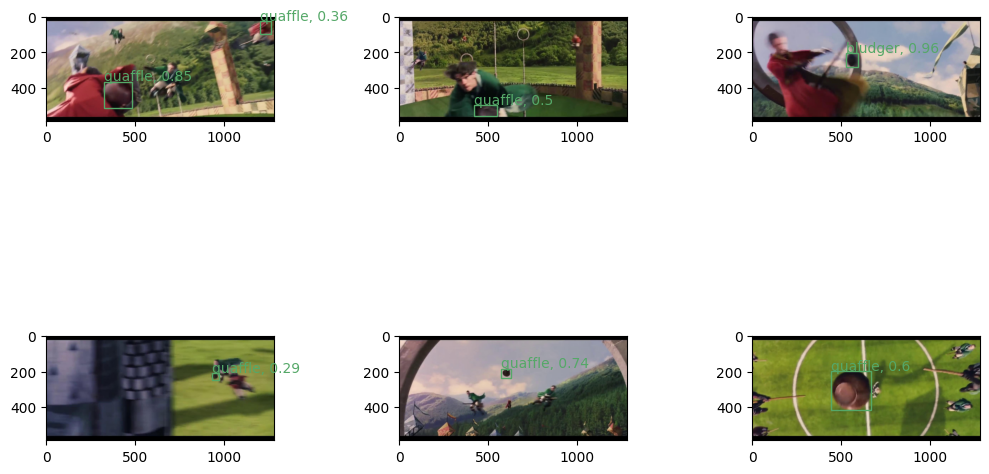

In [ ]:
validation = ['/content/valid/images/172.jpg',
              '/content/valid/images/174.jpg',
              '/content/valid/images/111.jpg',
              '/content/valid/images/114.jpg',
              '/content/valid/images/180.jpg',
              '/content/valid/images/155.jpg']
visualisation(validation)